# Восстановление золота из руды

### Постановка задачи
- Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
- Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.
- Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
Вам нужно:
Подготовить данные;
Провести исследовательский анализ данных;
Построить и обучить модель.
Чтобы выполнить проект, обращайтесь к библиотекам pandas, matplotlib и sklearn. Вам поможет их документация.

### Описание данных
Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

- Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

### Решение задачи

#### Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) #убираем ошибку
pd.set_option('display.max_rows', None)
from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV


#### Загрузка данных

In [2]:
data = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/Github/№9 Сборный золото регресия/gold_recovery_full_new (1).csv', 
                   index_col='date', parse_dates=True)
data_train = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/Github/№9 Сборный золото регресия/gold_recovery_train_new (1).csv', 
                         index_col='date', parse_dates=True)
data_test = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/Github/№9 Сборный золото регресия/gold_recovery_test_new (1).csv', 
                        index_col='date', parse_dates=True)

Посмотрим на датасеты, для этого напишем цикл dataset  и посмотрим основную информацию (количество строк, пропусков  и дубликатов)

In [3]:
full = [data, data_train, data_test]

for dataset in full:
    print('\n')
    print('Shape:', dataset.shape)
    print('Количество пропусков:', dataset.isna().sum().sum())
    print('Количество дубликатов:', dataset.duplicated().sum())



Shape: (19439, 86)
Количество пропусков: 4481
Количество дубликатов: 0


Shape: (14149, 86)
Количество пропусков: 4100
Количество дубликатов: 0


Shape: (5290, 52)
Количество пропусков: 90
Количество дубликатов: 0


Вывод: необхоимо избавиться от пропусков в датасетах для построения моделей

In [4]:
display(data_train.head(1))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


####  Проверка расчетов эффективности обогащения (MAE)

In [10]:
def recovery (c, f, t):
    result = (c*(f-t))/(f*(c-t))*100
    return result
 
data_train['recovery'] = recovery(data_train['rougher.output.concentrate_au'],
                                              data_train['rougher.input.feed_au'],
                                              data_train['rougher.output.tail_au'])
 
print('MAE обучающей выборки:',mean_absolute_error(data_train['rougher.output.recovery'], data_train['recovery']))


MAE обучающей выборки: 9.73512347450521e-15


 Вывод: MAE много меньше единицы,  эффективность обогащения на обучающей выборке рассчитана правильно

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера👍:</b> Верно, полученное значение оказалось в достаточной степени маленьким, чтобы можно было утверждать о правильности расчёта
</div>


В условии задачи сказано:
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей.

Найдем столбцы, которые отсуствуют в тестовой выборке

In [12]:
set_trian_test = list(set(data_train.columns) - set(data_test.columns))
set_trian_test

['rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'final.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_sol',
 'final.output.tail_pb',
 'rougher.calculation.au_pb_ratio',
 'primary_cleaner.output.concentrate_ag',
 'secondary_cleaner.output.tail_pb',
 'final.output.tail_au',
 'rougher.output.tail_ag',
 'secondary_cleaner.output.tail_ag',
 'recovery',
 'final.output.concentrate_ag',
 'rougher.calculation.sulfate_to_au_concentrate',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'final.output.tail_ag',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.tail_au',
 'final.output.tail_sol',
 'rougher.output.tail_sol',
 'final.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.calculation.floatbank11_sulfate_to_au_

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

### Вывод:
В тестовой выборке отсутствуют целевые признаки, а также параметры продукта и расчётные характеристики, имеющиеся в обучающей выборке. Эти параметры недоступны в test выборке, т.к. их невозможно получить/измерить во время выполнения технологического процесса.


### Предобработка данных

#### Заполнение пропусков с помощью метода линейной интерполяции

In [13]:
data = data.interpolate(method ='linear', limit_direction ='forward')
data_train = data_train.interpolate(method ='linear', limit_direction ='forward') 
data_test = data_test.interpolate(method ='linear', limit_direction ='forward')

In [14]:
#data_test.isna().sum()
#data_test.isna().sum()
#data_test.isna().sum()

Существует несколько методов борьбы с пропусками (заполнение медианой, нулями, удаление пропусков). Два послендний метода нам не подходяят, потому что они внесут слишком много изменений в данные и как следствие будет искажение модели.  пропусков у нас достаточно много для того,чтобы их просто удалить. Заполенне медианным значенеим или средним арифметическим таже будет вносить большое изменение в данные. Помню пример из консультации, когда несколько людей с разными  зп собрались в одной комнате и при подсчете среднего арифметического  получилось, что средняя зп близка к максимальной,  что не соотвествует реальности. в данном случе подходит медианнй метод расчета: медиана делит пополам все значения и показывает число, которое находится  между  этими группами. Два этих метода хороши (на мой  взгляд), когда наши  значения в датасете близки друг к другу и нет выбросов.  В нашем  же случае  пропуски необходимо заполнить с учетом значений  данных вокруг пропуска. Поэтому и был выбран метод линейной интреполяции, поскольку он основан на аппроксимации. Мы имеем некоторый разброс данных и с помощью подбора уравнения y=ax+b строится прямая, которая и поможет спрогнозировать пропущенные значения с учетом известных значений. 

#### Удаление из обучающей выборки всех признаков, которых нет в тестовой выборке

Удалим из обучающей выборки колонки, которых нет в тестовой выборке, кроме целевых признаков. А в текстовую выборку добавим целевые признаки.

In [15]:
full_df_merged = data[['rougher.output.recovery', 'final.output.recovery']]
data_test = data_test.merge(full_df_merged, on='date', how='left')

### Анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

- исходные данные rougher.input.feed
- сырье после флотации rougher.output.concentrate
- черновой концентрат primary_cleaner.output
- финальный концентрат final.output.concentrate

In [16]:
def metal_every_level (i,r,p,f,title):
    
    
    
    plt.figure(figsize = [12,9])
    
    plt.hist(i,bins = 100, alpha= 0.5, label ='суммарная концентрация в сырье')
    plt.hist(r,bins = 100, alpha= 0.5, label ='суммарная концентрация во время флотации')
    plt.hist(p,bins = 100, alpha= 0.5, label ='суммарная концентрация в черновом концентрате')
    plt.hist(f,bins = 100, alpha= 0.5, label ='суммарная концентрация в финале')

    
    plt.title(title)
    plt.legend()
    
    plt.show()

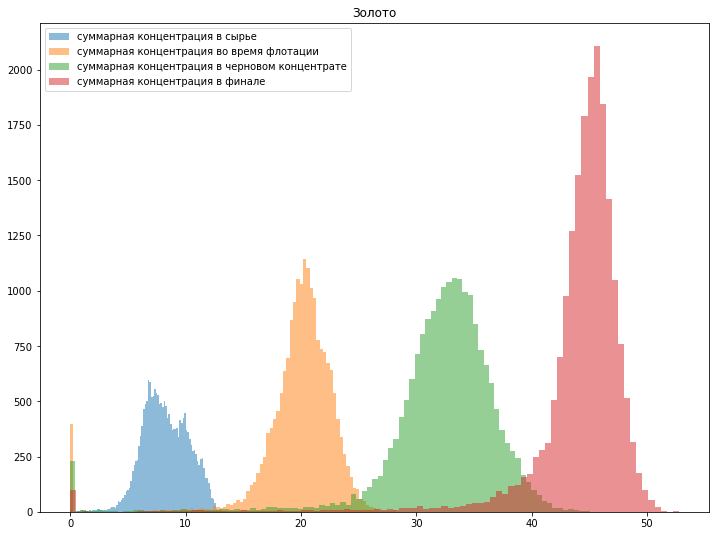

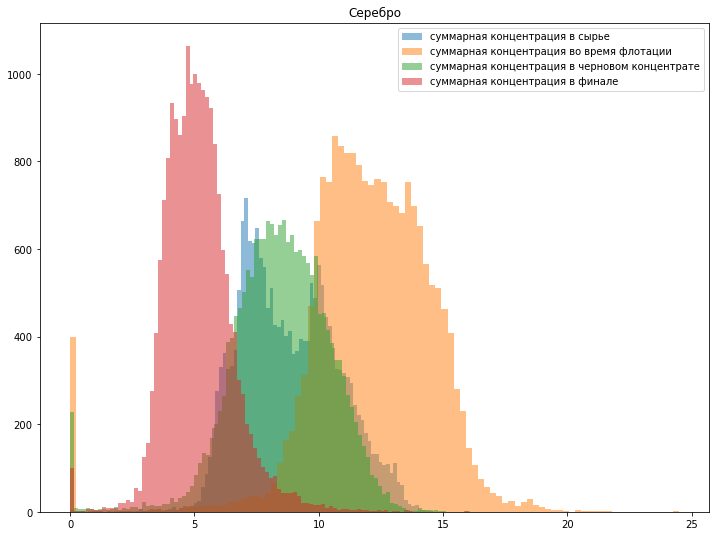

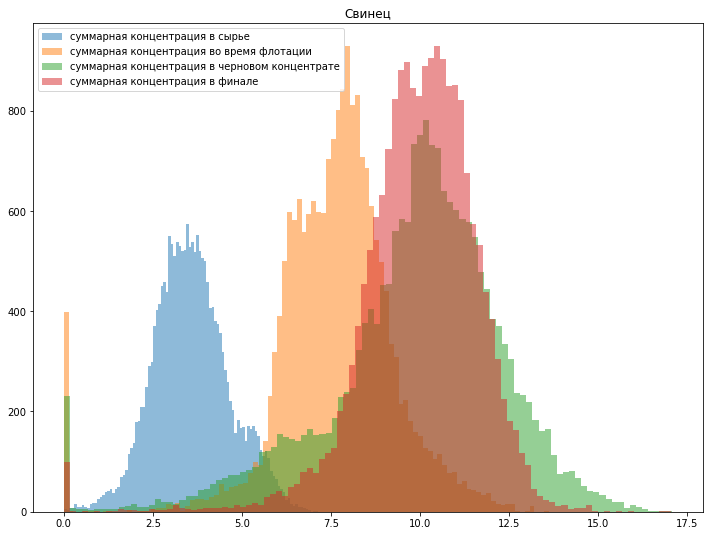

In [17]:
metal_every_level(data['rougher.input.feed_au'], 
           data['rougher.output.concentrate_au'], 
           data['primary_cleaner.output.concentrate_au'], 
           data['final.output.concentrate_au'], 
           'Золото')
metal_every_level(data['rougher.input.feed_ag'], 
           data['rougher.output.concentrate_ag'], 
           data['primary_cleaner.output.concentrate_ag'], 
           data['final.output.concentrate_ag'], 
           'Серебро')
metal_every_level(data['rougher.input.feed_pb'], 
           data['rougher.output.concentrate_pb'], 
           data['primary_cleaner.output.concentrate_pb'], 
           data['final.output.concentrate_pb'], 
           'Свинец')

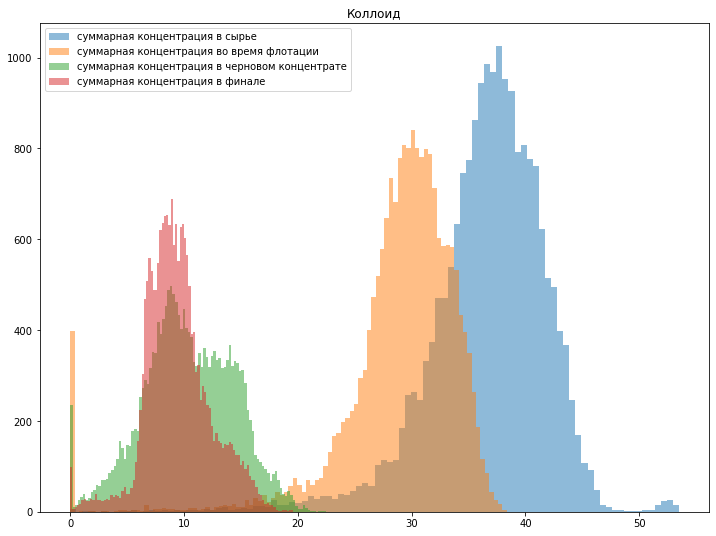

In [18]:
metal_every_level(data['rougher.input.feed_sol'], 
           data['rougher.output.concentrate_sol'], 
           data['primary_cleaner.output.concentrate_sol'], 
           data['final.output.concentrate_sol'], 
           'Коллоид')

### Концентрация всех веществ (золото, серебро, свинец, коллоид) на разных этапах (сырье, черновой концентрат, финал)

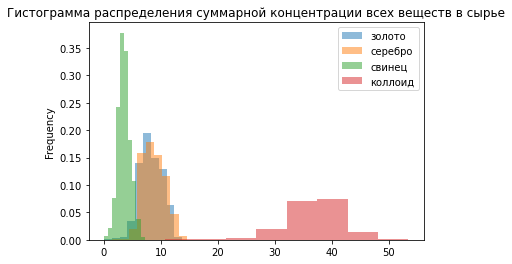

In [37]:
rougher_au = data ['rougher.input.feed_au']
rougher_ag = data ['rougher.input.feed_ag']
rougher_pb = data ['rougher.input.feed_pb']
rougher_sol = data ['rougher.input.feed_sol']

rougher_au.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='золото', density=True)
rougher_ag.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='серебро', density=True)
rougher_pb.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='свинец', density=True)
rougher_sol.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='коллоид', density=True)

plt.legend(loc='upper right')
plt.title ('Гистограмма распределения суммарной концентрации всех веществ в сырье')

plt.show()

Видим, что изначально в сырье больше всего коллоида

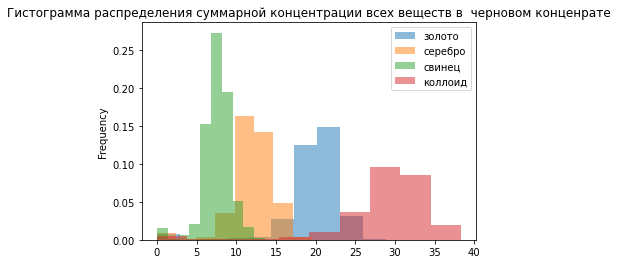

In [38]:
rougher_output_au = data ['rougher.output.concentrate_au']
rougher_output_ag = data ['rougher.output.concentrate_ag']
rougher_output_pb = data ['rougher.output.concentrate_pb']
rougher_output_sol = data ['rougher.output.concentrate_sol']

rougher_output_au.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='золото', density=True)
rougher_output_ag.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='серебро', density=True)
rougher_output_pb.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='свинец', density=True)
rougher_output_sol.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='коллоид', density=True)

plt.legend(loc='upper right')
plt.title ('Гистограмма распределения суммарной концентрации всех веществ в  черновом конценрате')

plt.show()

После проведения предварительной очистки наблюдаем небольшое уменьшение коллоида  и увеличение золота, серебра и свинца

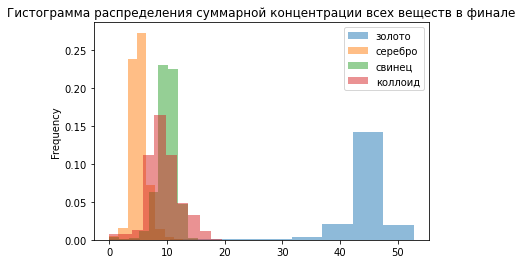

In [39]:
fial_au = data ['final.output.concentrate_au']
fial_ag = data ['final.output.concentrate_ag']
fial_pb = data ['final.output.concentrate_pb']
fial_sol = data ['final.output.concentrate_sol']

fial_au.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='золото', density=True)
fial_ag.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='серебро', density=True)
fial_pb.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='свинец', density=True)
fial_sol.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='коллоид', density=True)

plt.legend(loc='upper right')
plt.title ('Гистограмма распределения суммарной концентрации всех веществ в финале')

plt.show()

Вывод:

На построенных гистограммах мы видим,что на разных этапах разные элементы ведут себя по-разному. Например у серебра  максимальное количество концертрации во время  флотации,а у других элементов (золото, свинец) на финальном этапе. Полагаю, что серебро и свинец плохо отделяетсяя  флотацией, поэтому и растет концентрация на этом этапе. 
Также мне было интересно посмотреть концентрацию металлов на на каждом этапе и я построила другой вид диаграмм (все металлы на каждом из этапов), чтобы увидеть распеределение. 

#### Сравнение  размеров гранул сырья на обучающей и тестовой выборках

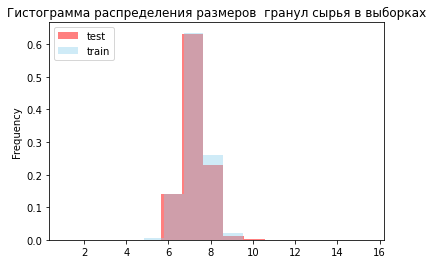

In [22]:
feed_size_test = data_test['primary_cleaner.input.feed_size']
feed_size_train = data_train['primary_cleaner.input.feed_size']

feed_size_test.plot(bins = 10, kind = 'hist', alpha= 0.5, label ='test', density=True, color='red')
feed_size_train.plot(bins = 10, kind = 'hist', alpha= 0.4, label ='train', density=True, color= 'skyblue')

plt.legend(loc='upper left')
plt.title ('Гистограмма распределения размеров  гранул сырья в выборках')
plt.show()

### Вывод: 
Видно, что на входе процесса стараются поддерживать размер гранул в 55-60 микрон, есть незначительное смещение распределения от нормального в сторону увеличения гранул. Также, на тестовой выборке имеется большее значение очень маленьких гранул. Визуально значительных различий между train и test не наблюдается. Можем использовать данные для оценки моделей


#### Рассмотрение суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [23]:
def total(df):
    rougher_input_total = (df['rougher.input.feed_au'] 
                          + df['rougher.input.feed_ag'] 
                          + df['rougher.input.feed_pb'] 
                          + df['rougher.input.feed_sol'])
    rougher_output_total = (df['rougher.output.concentrate_au'] 
                            + df['rougher.output.concentrate_ag'] 
                            + df['rougher.output.concentrate_pb'] 
                            + df['rougher.output.concentrate_sol'])
    primari_cleaner_output_total = (df['primary_cleaner.output.concentrate_au'] 
                            + df['primary_cleaner.output.concentrate_ag'] 
                            + df['primary_cleaner.output.concentrate_pb'] 
                            + df['primary_cleaner.output.concentrate_sol'])
    final_output_total = (df['final.output.concentrate_au'] 
                          + df['final.output.concentrate_ag'] 
                          + df['final.output.concentrate_pb'] 
                          + df['final.output.concentrate_sol'])
    return rougher_input_total,rougher_output_total,primari_cleaner_output_total,final_output_total

In [24]:
def hist (i,r,p,f,x,y,title):
    plt.figure(figsize = [12,9])
    
    plt.hist(i,bins = 100, alpha= 0.5, label ='суммарная концентрация в сырье')
    plt.hist(r,bins = 100, alpha= 0.5, label ='суммарная концентрация во время флотации')
    plt.hist(p,bins = 100, alpha= 0.5, label ='суммарная концентрация в черновом концентрате')
    plt.hist(f,bins = 100, alpha= 0.5, label ='суммарная концентрация в финале')
    
    plt.title(title)
    plt.legend()
    
    plt.xlim([0,x])
    plt.ylim([0,y])
    
    plt.show()

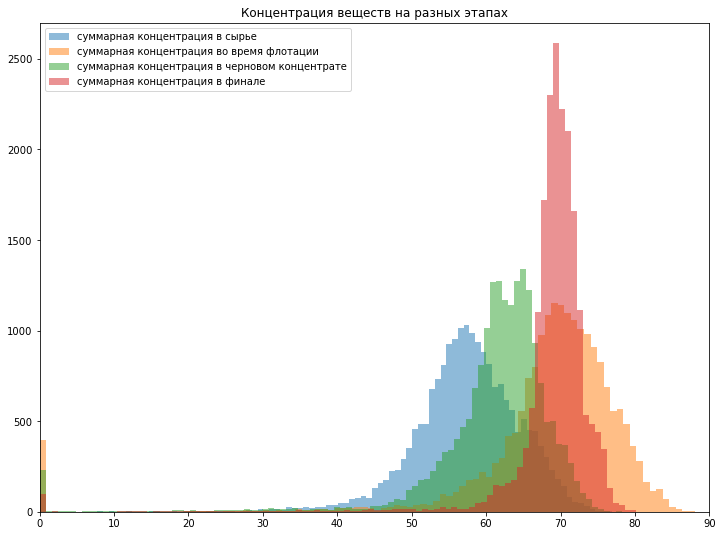

In [25]:
i,r,p,f = total(data)
hist(i,r,p,f,90,2700,"Концентрация веществ на разных этапах")

#### Вывод
На гистограмме распределения суммарных концентраций на каждом из этапов мы видим  большое количество нулевых значений. Дело в том, что хоть грамм чего-нибудь но есть в "суммарной руде"- соль+золото+серебро+свинец - точно что-то должно быть.. А если мы имеем ноль, значит большая вероятность неточности измерений. Общая идея какая с суммарной концентрацией: отдельно по каждой руде нуль может быть (взяли лопату руды - и нет там золота - не всегда же есть крупинки..). А вот нуль суммарно - это уже вряд ли (в этой лопате хоть что-то но будет).


In [26]:
features_rough_concentrate = [
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
]

features_input_concentrate = [
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
]
features_final_concentrate = [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
]

display(data_test.shape)
display(data_train.shape)



data_full = data.loc[data_test.index]


display(data_test.shape)
display(data_train.shape)

(5290, 54)

(14149, 87)

(5290, 54)

(14149, 87)

Удаление нулевых значений

In [27]:
data_train = data_train[data_train[features_input_concentrate].sum(1) > 0]
data_train = data_train[data_train[features_rough_concentrate].sum(1) > 0]
data_train = data_train[data_train[features_final_concentrate].sum(1) > 0]

data_test = data_test[data_full[features_input_concentrate].sum(1) > 0]
data_test = data_test[data_full[features_rough_concentrate].sum(1) > 0]
data_test = data_test[data_full[features_final_concentrate].sum(1) > 0]

/var/folders/0t/x_91wd9n6xj5w224pdngwnl80000gn/T/ipykernel_2031/2174631406.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_test = data_test[data_full[features_final_concentrate].sum(1) > 0]


### Построение модели


#### Подготовка данных и разделение на выборки


Разобьем выборки на features и target

In [28]:
features_train = data_train.drop(columns=["rougher.output.recovery", "final.output.recovery"], axis=1)
target_train = data_train[["rougher.output.recovery", "final.output.recovery"]]

features_test = data_test.drop(columns=["rougher.output.recovery", "final.output.recovery"], axis=1)
target_test = data_test[["rougher.output.recovery", "final.output.recovery"]]

In [29]:
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(13795, 85)

(13795, 2)

(5154, 52)

(5154, 2)

Удалим столбцы, характеризующие этапы последующей обработки, из обучающей выборки, которые обнаружили ранее. 
Удалим из списка 'rougher.output.recovery', 'final.output.recovery'


In [30]:
features_train = features_train.drop(columns = ['rougher.output.concentrate_ag',
                                                'primary_cleaner.output.tail_au',
                                                'final.output.tail_ag',
                                                'final.output.concentrate_sol',
                                                'rougher.output.tail_pb',
                                                'recovery',
                                                'final.output.tail_au',
                                                'primary_cleaner.output.concentrate_au',
                                                'primary_cleaner.output.concentrate_pb',
                                                'rougher.output.concentrate_sol',
                                                'rougher.output.concentrate_au',
                                                'rougher.calculation.au_pb_ratio',
                                                'rougher.calculation.sulfate_to_au_concentrate',
                                                'rougher.output.tail_au',
                                                'rougher.output.concentrate_pb',
                                                'final.output.tail_sol',
                                                'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                                'rougher.output.tail_sol',
                                                'primary_cleaner.output.tail_pb',
                                                'primary_cleaner.output.tail_ag',
                                                
                                                
                                                'final.output.tail_pb',
                                                'rougher.output.tail_ag',
                                                'secondary_cleaner.output.tail_sol',
                                                'primary_cleaner.output.tail_sol',
                                                'secondary_cleaner.output.tail_au',
                                                'secondary_cleaner.output.tail_pb',
                                                'rougher.calculation.floatbank11_sulfate_to_au_feed',
                                                'final.output.concentrate_au',
                                                'secondary_cleaner.output.tail_ag',
                                                'primary_cleaner.output.concentrate_ag',
                                                'final.output.concentrate_ag',
                                                'final.output.concentrate_pb','primary_cleaner.output.concentrate_sol'],axis = 1)

Посмотрим на итоговое количество строчек и столбцов для модели

In [31]:
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(13795, 52)

(13795, 2)

(5154, 52)

(5154, 2)

#### Функция для вычисления итоговой sMAPE.

In [32]:
def calculate_smape(target_actual, target_predictions):
    numerator = np.abs(target_actual - target_predictions)
    denominator = (np.abs(target_actual) + np.abs(target_predictions)) / 2 
    return 1 / len(target_actual) * np.sum(numerator / denominator) * 100 
  
def calculate_final_smape(target_actual, target_predictions):
    target_actual_rougher = target_actual['rougher.output.recovery']
    target_actual_final = target_actual['final.output.recovery']
    target_predictions_rougher = target_predictions[:, 0]
    target_predictions_final = target_predictions[:, 1]
    return 0.25 * calculate_smape(target_actual_rougher, target_predictions_rougher) + 0.75 * calculate_smape(target_actual_rougher, target_predictions_rougher)

smape_scorer = make_scorer(calculate_final_smape, greater_is_better=False)

 ### Обучение моделей

 #### Линейная регрессия

In [33]:
param_grid_lg = {'normalize': [False, True]}
lg = LinearRegression()
grid_search_lg = GridSearchCV(estimator=lg, param_grid=param_grid_lg, 
                              scoring=smape_scorer, cv=5, n_jobs=-1)
grid_search_lg.fit(features_train, target_train)

print("Лучшее значение smape для LinearRegression:", -grid_search_lg.best_score_.round(4),
      "\nПараметры модели:", grid_search_lg.best_params_)

Лучшее значение smape для LinearRegression: 7.2338 
Параметры модели: {'normalize': False}


 #### Случайный лес 

Создадим параметры для модели RandomForestRegressor

In [34]:
param_grid_rf = {
    'max_depth': [16],
    'n_estimators': range(100, 121, 10)
}

rf = RandomForestRegressor(random_state=12345)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                              scoring=smape_scorer, cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(features_train, target_train)

print("Лучшее значение smape для RandomForestRegressor:", -grid_search_rf.best_score_.round(4),
      "\nЛучшая модель:", grid_search_rf.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшее значение smape для RandomForestRegressor: 6.7209 
Лучшая модель: {'max_depth': 16, 'n_estimators': 110}


 #### Дерево решений 

In [35]:
# Создадим параметры grid для модели DecisionTreeRegressor
param_grid_dt = {'max_depth': range(2, 8)}
# Создадим модель
dt = DecisionTreeRegressor(random_state=12345)
# Instantiate the grid search model
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, scoring=smape_scorer, cv=5, n_jobs=-1)

grid_search_dt.fit(features_train, target_train)

print("Лучшее значение smape для DecisionTreeRegressor:", -grid_search_dt.best_score_.round(4),
      "\nЛучшая модель:", grid_search_dt.best_params_)

Лучшее значение smape для DecisionTreeRegressor: 7.0735 
Лучшая модель: {'max_depth': 4}


Вывод: Лучше всего показала себя модель DecisionTreeRegressor, у которой минимальный параметр sMape. LinearRegression: 7.07
параметр {'max_depth': 4}

### Тестирование модели

In [36]:
model_lg_best = LinearRegression()
model_lg_best.fit(features_train, target_train)
predicted_test = model_lg_best.predict(features_test)
print('sMape LinearRegression на тестовой выборке:', calculate_final_smape(target_test, predicted_test))

model_dt_best = DecisionTreeRegressor(random_state=12345, max_depth=4)
model_dt_best.fit(features_train, target_train)
predicted_test = model_dt_best.predict(features_test)
print('sMape DecisionTreeRegressor на тестовой выборке:', calculate_final_smape(target_test, predicted_test))

model_rf_best = RandomForestRegressor(random_state=12345, max_depth=16, n_estimators=110)
model_rf_best.fit(features_train, target_train)
predicted_test = model_rf_best.predict(features_test)
print('sMape RandomForestRegressor на тестовой выборке:', calculate_final_smape(target_test, predicted_test))

sMape LinearRegression на тестовой выборке: 4.826770035137061
sMape DecisionTreeRegressor на тестовой выборке: 4.9830012579408045
sMape RandomForestRegressor на тестовой выборке: 4.9846039241791695
[CV] END .....................max_depth=16, n_estimators=100; total time= 1.6min
[CV] END .....................max_depth=16, n_estimators=110; total time= 1.7min
[CV] END .....................max_depth=16, n_estimators=120; total time= 1.8min
[CV] END .....................max_depth=16, n_estimators=120; total time= 1.5min
[CV] END .....................max_depth=16, n_estimators=100; total time= 1.6min
[CV] END .....................max_depth=16, n_estimators=110; total time= 1.6min
[CV] END .....................max_depth=16, n_estimators=110; total time= 1.7min
[CV] END .....................max_depth=16, n_estimators=120; total time= 1.5min
[CV] END .....................max_depth=16, n_estimators=100; total time= 1.6min
[CV] END .....................max_depth=16, n_estimators=110; total time=

Общий вывод: Подготовлена модель обработки  данных. Применен лучший подход к обработке  -- метод линейной регрессии. Модель LinearRegression показала лучшее sMape=4.83 на тестовой выборке